In [1]:
dataset_name = "ec2_cpu_utilization_ac20cd"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


# Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-15 00:49:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-02 14:29:00
End date:  2014-04-16 14:49:00
Missing time stamps: 
 DatetimeIndex(['2014-04-07 13:39:00', '2014-04-07 13:44:00',
               '2014-04-14 23:49:00', '2014-04-14 23:54:00',
               '2014-04-14 23:59:00'],
              dtype='datetime64[ns]', freq=None)
Length:  4037
Time step size:  5min
Start Date:  2014-04-02 14:29:00
End Date:  2014-04-16 14:49:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [3580]


# Donut

Trainable Parameters              (58,150 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (120,)         120
donut/p_x_given_z/x_mean/kernel  (100, 120)  12,000
donut/p_x_given_z/x_std/bias     (120,)         120
donut/p_x_given_z/x_std/kernel   (100, 120)  12,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (120, 100)  12,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 10, ETA 16.41s] Learning rate decreased to 

INFO:tensorflow:Restoring parameters from /tmp/tmpas5l2nmq/variables.dat-100


[Epoch 250/256, Step 250, ETA 0.1137s] Learning rate decreased to 7.525434581650002e-07


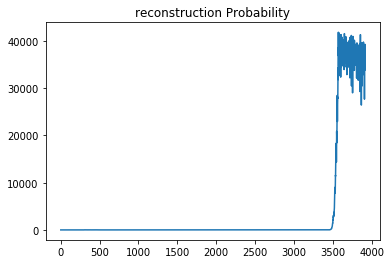

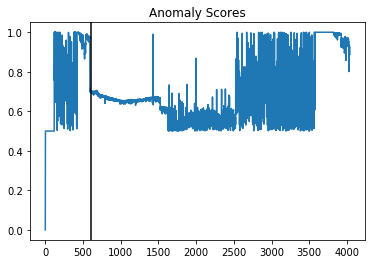

Time:  32.42605185508728


['anomaly_scores/Donut/ec2_cpu_utilization_ac20cd_no_fill']

In [4]:
save_path = "anomaly_scores/Donut/" + dataset_name+ "_no_fill"
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

In [5]:
# no seasonality. cannot use